In [365]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [367]:
data = pd.read_csv('amazon_stock_price.csv')
data.head(5)

,date,open,high,low,close,volume
0,1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1,1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
2,1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
3,1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
4,1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000


In [369]:
data = data.sort_values('date')
data.head(5)

,date,open,high,low,close,volume
0,1997-05-15,0.1219,0.1250,0.0964,0.0979,1443120000
1,1997-05-16,0.0984,0.0990,0.0854,0.0865,294000000
2,1997-05-19,0.0880,0.0885,0.0812,0.0854,122136000
3,1997-05-20,0.0865,0.0875,0.0818,0.0818,109344000
4,1997-05-21,0.0818,0.0823,0.0688,0.0714,377064000


In [371]:
data['date'] = pd.to_datetime(data['date'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6685 entries, 0 to 6684
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    6685 non-null   datetime64[ns]
 1   open    6685 non-null   float64       
 2   high    6685 non-null   float64       
 3   low     6685 non-null   float64       
 4   close   6685 non-null   float64       
 5   volume  6685 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 313.5 KB


In [373]:
def fill_dataset(data):
    data_copy = data.copy()
    data_copy.set_index('date', inplace=True)
    full_dates = pd.date_range(start=data_copy.index.min(), end=data_copy.index.max(), freq='D')
    data_copy = data_copy.reindex(full_dates)
    return data_copy

In [375]:
data = fill_dataset(data)
data.head(5)

,open,high,low,close,volume
1997-05-15,0.1219,0.1250,0.0964,0.0979,1.443120e+09
1997-05-16,0.0984,0.0990,0.0854,0.0865,2.940000e+08
1997-05-17,NaN,NaN,NaN,NaN,NaN
1997-05-18,NaN,NaN,NaN,NaN,NaN
1997-05-19,0.0880,0.0885,0.0812,0.0854,1.221360e+08


In [377]:
def interpolate_data(data, columns):
    data_copy = data.copy()
    for column in columns:
        data_copy[column] = data_copy[column].interpolate(limit_direction='both')
    return data_copy

In [379]:
data = interpolate_data(data,['open','high','low','close','volume'])
data.head()

,open,high,low,close,volume
1997-05-15,0.121900,0.1250,0.0964,0.097900,1.443120e+09
1997-05-16,0.098400,0.0990,0.0854,0.086500,2.940000e+08
1997-05-17,0.094933,0.0955,0.0840,0.086133,2.367120e+08
1997-05-18,0.091467,0.0920,0.0826,0.085767,1.794240e+08
1997-05-19,0.088000,0.0885,0.0812,0.085400,1.221360e+08


In [381]:
data['volume'] = data['volume'].apply(lambda x: int(x))

In [383]:
data.head(5)

,open,high,low,close,volume
1997-05-15,0.121900,0.1250,0.0964,0.097900,1443120000
1997-05-16,0.098400,0.0990,0.0854,0.086500,294000000
1997-05-17,0.094933,0.0955,0.0840,0.086133,236712000
1997-05-18,0.091467,0.0920,0.0826,0.085767,179424000
1997-05-19,0.088000,0.0885,0.0812,0.085400,122136000


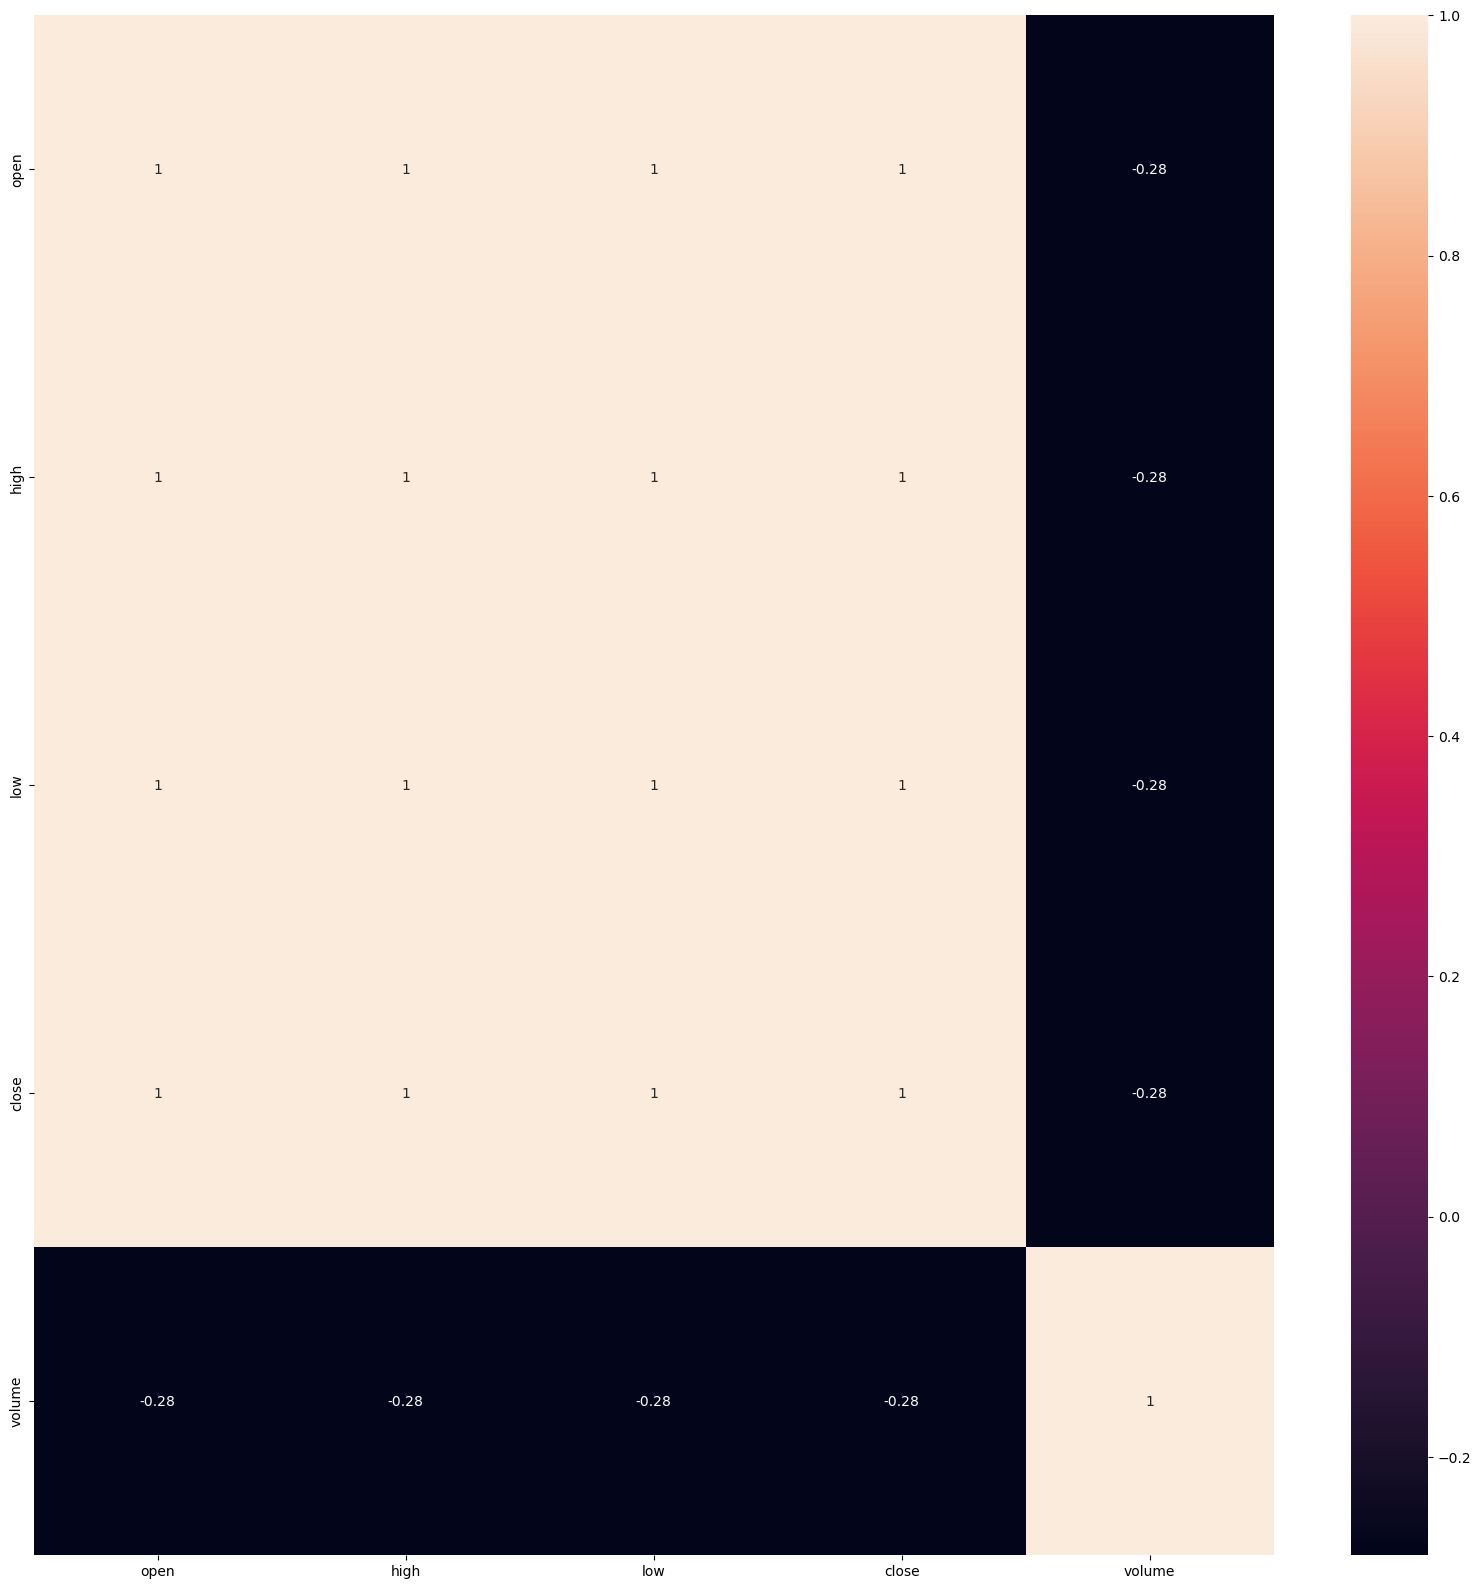

In [385]:
plt.figure(figsize=(20, 20))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [387]:
data.drop('high',axis=1,inplace=True)
data.drop('low',axis=1,inplace=True)
data.drop('open',axis=1,inplace=True)
data.drop('volume',axis=1,inplace=True)
data.head(5)

,close
1997-05-15,0.097900
1997-05-16,0.086500
1997-05-17,0.086133
1997-05-18,0.085767
1997-05-19,0.085400


In [389]:
data = data.reset_index()
data.head(5)

,index,close
0,1997-05-15,0.097900
1,1997-05-16,0.086500
2,1997-05-17,0.086133
3,1997-05-18,0.085767
4,1997-05-19,0.085400


In [391]:
data.drop('index',axis=1,inplace=True)
data.head(5)

,close
0,0.097900
1,0.086500
2,0.086133
3,0.085767
4,0.085400


In [393]:
for_lags = ['close']
for feature in for_lags:
    for lag in range(1,4):
        data[f'{feature}_lag_{lag}']= data[feature].shift(lag)

data = data.dropna()

In [395]:
data.head(5)

,close,close_lag_1,close_lag_2,close_lag_3
3,0.085767,0.086133,0.086500,0.097900
4,0.085400,0.085767,0.086133,0.086500
5,0.081800,0.085400,0.085767,0.086133
6,0.071400,0.081800,0.085400,0.085767
7,0.069800,0.071400,0.081800,0.085400


In [397]:
from sklearn.model_selection import train_test_split

data_new = data.drop('close',axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(data_new,  data['close'], test_size=0.2)

In [399]:
from xgboost import XGBRegressor


model = XGBRegressor(objective ='reg:linear',
    colsample_bytree = 0.3, learning_rate = 0.1,
    max_depth = 5, alpha = 2, n_estimators = 10)

model.fit(X_train,Y_train)
y_pred=model.predict(X_test)

C:\Users\HP\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:34:07] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\objective\regression_obj.cu:227: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [401]:
from sklearn.metrics import r2_score
print("r2 score: ",r2_score(Y_test,y_pred))

r2 score:  0.87581498740125
